In [ ]:
import sys
sys.path.insert(1, '/users/facsupport/asharma/RNN-shifts/preprocessing')

from data_prep import initial_preprocess

### Generate dataset

RAW_DATA_PATH = '/export/storage_adgandhi/PBJ_data_prep/pbj_full.csv'
PREPROCESSED_DIR = '/users/facsupport/asharma/Data/test'

df, info = initial_preprocess(
    RAW_DATA_PATH, PREPROCESSED_DIR,
    nrows=500000,  
    fill_missing_shifts=True,
    normalize=False,
    day_of_week=True,
    prev_shifts=30,
    fac_data=True
)
df
print(df.columns)

Loading preprocessed data from '/users/facsupport/asharma/Data/testpbj_nrows_500000_zeros_prev_shifts_30_dow_fac.csv'...
Failed.
Loading data...
Filling missing shifts...
Adding previous shifts...


In [75]:
import pandas as pd
import lightgbm as lgb

# Keep "interesting" jobs (TODO - use strings instead)
df = df[df['job_title'].isin([33,34,35,11,12,3,5,16,17])]
df['date'] = pd.to_datetime(df['date']).astype(int)
# Convert necessary values to boolean
df.multifac = df.multifac.map(dict(Yes=1, No=0))
df.profit = df.profit.map(dict(Yes=1, No=0))
#Drop employee id and date columns
df = df.drop(columns=['employee_id','date'])

# %%
# ========================================
#          SPLIT & PREP DATAFRAME
# ========================================

inputs = df.drop(['t_0', 'hours'], axis=1)
labels = df.filter(['t_0'])

# Weights to split data set
TRAINING_WEIGHT = 0.7
VALIDATION_WEIGHT = 0.2
TEST_WEIGHT = 0.1

n = len(df)
weights_sum = TRAINING_WEIGHT + VALIDATION_WEIGHT + TEST_WEIGHT
split1 = int(TRAINING_WEIGHT / weights_sum * n)
split2 = int((TRAINING_WEIGHT + VALIDATION_WEIGHT) / weights_sum * n)

train_inputs, train_labels = inputs[:split1], labels[:split1]
val_inputs, val_labels = inputs[split1:split2], labels[split1:split2]
test_inputs, test_labels = inputs[split2:], labels[split2:]

print(train_inputs)
print(train_labels)


       t_1   t_2   t_3   t_4   t_5   t_6   t_7   t_8   t_9  t_10  ...  t_30  \
0     9.25  8.75  0.00  0.00  8.75  9.00  9.25  8.50  8.75  0.00  ...  8.75   
1     9.25  9.25  8.75  0.00  0.00  8.75  9.00  9.25  8.50  8.75  ...  9.50   
2     8.50  9.25  9.25  8.75  0.00  0.00  8.75  9.00  9.25  8.50  ...  8.00   
3     8.25  8.50  9.25  9.25  8.75  0.00  0.00  8.75  9.00  9.25  ...  0.00   
4     0.00  8.25  8.50  9.25  9.25  8.75  0.00  0.00  8.75  9.00  ...  8.50   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
7933  0.00  8.00  8.75  0.00  8.50  0.00  0.00  8.50  8.25  8.25  ...  7.75   
7934  0.00  0.00  8.00  8.75  0.00  8.50  0.00  0.00  8.50  8.25  ...  0.00   
7935  7.75  0.00  0.00  8.00  8.75  0.00  8.50  0.00  0.00  8.50  ...  0.00   
7936  8.50  7.75  0.00  0.00  8.00  8.75  0.00  8.50  0.00  0.00  ...  8.25   
7937  0.00  8.50  7.75  0.00  0.00  8.00  8.75  0.00  8.50  0.00  ...  9.75   

      job_title  prov_id  pay_type  day_of_week  nr

In [76]:
# %%
# ========================================
#          DATAFRAME TO LGB DS
# ========================================

cats = ['job_title', 'prov_id', 'pay_type', 'day_of_week', 'nresid', 'multifac', 'profit']

train_data = lgb.Dataset(train_inputs, label=train_labels, categorical_feature=cats)
val_data = lgb.Dataset(val_inputs, label=val_labels, categorical_feature=cats)
test_data = lgb.Dataset(test_inputs, label=test_labels, categorical_feature=cats)
print(train_data)

In [77]:
# %%
# ========================================
#            TRAIN WITH LGB
# ========================================
param = {
  'num_leaves': 100,
  'learning_rate': 0.1,
  'metric': 'mse',
}
evals_result = {}
bst = lgb.train(param, train_data, valid_sets=[val_data], evals_result=evals_result, early_stopping_rounds=5)

/users/facsupport/asharma/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2574
[LightGBM] [Info] Number of data points in the train set: 5341, number of used features: 37
[LightGBM] [Info] Start training from score 4.445920


/users/facsupport/asharma/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/users/facsupport/asharma/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's l2: 14.0551
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 13.239
[3]	valid_0's l2: 12.5551
[4]	valid_0's l2: 12.0198
[5]	valid_0's l2: 11.5619
[6]	valid_0's l2: 11.2419
[7]	valid_0's l2: 10.9603
[8]	valid_0's l2: 10.694
[9]	valid_0's l2: 10.4255
[10]	valid_0's l2: 10.2467
[11]	valid_0's l2: 10.0986
[12]	valid_0's l2: 9.96372
[13]	valid_0's l2: 9.88655
[14]	valid_0's l2: 9.78982
[15]	valid_0's l2: 9.71529
[16]	valid_0's l2: 9.63039
[17]	valid_0's l2: 9.58489
[18]	valid_0's l2: 9.5856
[19]	valid_0's l2: 9.54084
[20]	valid_0's l2: 9.50515
[21]	valid_0's l2: 9.49167
[22]	valid_0's l2: 9.47558
[23]	valid_0's l2: 9.41362
[24]	valid_0's l2: 9.40099
[25]	valid_0's l2: 9.36674
[26]	valid_0's l2: 9.35547
[27]	valid_0's l2: 9.35792
[28]	valid_0's l2: 9.34988
[29]	valid_0's l2: 9.3401
[30]	valid_0's l2: 9.3473
[31]	valid_0's l2: 9.32129
[32]	valid_0's l2: 9.29619
[33]	valid_0's l2: 9.29349
[34]	valid_0's l2: 9.30063
[35]	valid_0's l2: 9.30691
[36]	vali

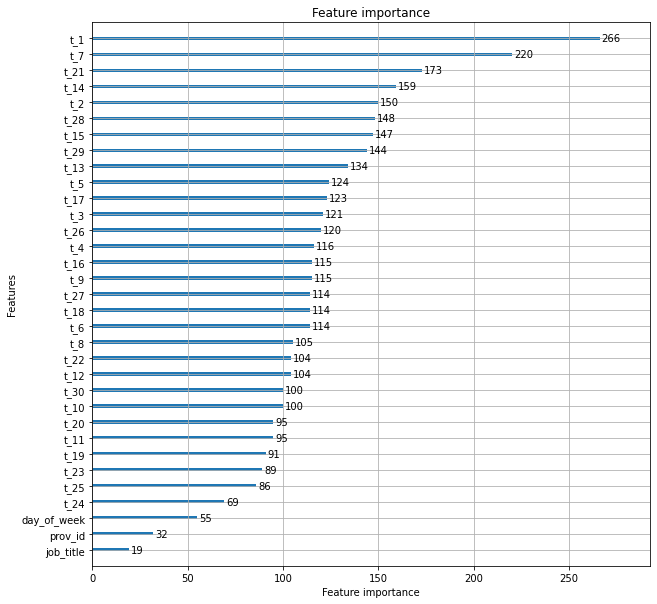

In [78]:
# %%
# =========================================
#          LGB Influence Scores
# =========================================

axes = lgb.plot_importance(bst,figsize=(10,10))